In [4]:
%matplotlib inline
#from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
#from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.applications.vgg19 import preprocess_input, decode_predictions
from keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D,MaxPooling2D
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Input

from glob import glob
from itertools import cycle,zip_longest

import PIL
from PIL import Image
import matplotlib.pyplot as plt
import json
import time

from sklearn.cluster import KMeans

import numpy as np
import lda
import collections

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import matplotlib

/home/ubuntu/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Data Processing - Create Batch Generator

In [15]:
#run extract_files.py to process the image files
total_image_number = 206900

## Process .json file with image labels 

In [5]:
def process_label_file():
    #with open("photos.json") as infile:
    with open("../photos.json") as infile:
      val = infile.readlines()

    id = []
    label = []
    for i in val:
      #print(i)
      #print("ID: %s, Label: %s" % (json.loads(i)['photo_id'],json.loads(i)['label']))
      id.append(json.loads(i)['photo_id'])
      label.append(json.loads(i)['label'])
    id = np.asarray(id)
    label = np.asarray(label)
    info = np.vstack((id,label))
    info = info.T
    info[0,:]
    return info

In [ ]:
#align images with labels in used_im_labels array
def map_label_file_to_names(json_labels,names):
    process_names = names
    new_names = [(name.replace("/home/ubuntu/project/le49/photos/","")).replace(".jpg","") for name in process_names]
    used_im_labels = [json_labels[np.where(json_labels[:,0]==name)[0][0],1] for name in new_names]
    return np.asarray(used_im_labels)

In [6]:
info = process_label_file()

In [ ]:
#used_im_labels = map_label_file_to_names(info,names)
#np.save('labels.npy', used_im_labels) 

In [7]:
used_im_labels = np.load('labels.npy')

In [8]:
#number of clusters
uniq_elem = np.unique(info[:,1])

## Define Model

In [9]:
# refer to extract_files.py for model definiton

## Load Extracted Features

In [10]:
#refer to extract_files.py for creation of these files
names = np.load('names.npy')

In [11]:
final_features_b2_av = np.load('predictions_block2_global.npy')

In [12]:
final_features_b5_av = np.load('predictions_block5_global.npy')

In [13]:
final_features_b2_max = np.load('predictions_block2_max.npy')

In [14]:
final_features_b5_max = np.load('predictions_block5_max.npy')

## Process features into word representations

** Process by normalising the rows and setting values > 0.5 to 1 otherwise 0 **

In [25]:
def process_features_with_normalising(final_features):
    processed_features_list = []
    mean = np.mean(final_features,axis=1)
    min = np.min(final_features,axis=1)
    max = np.max(final_features,axis=1)
    for row in range(final_features.shape[0]):
      if((100*row/final_features.shape[0]) % 10 == 0 and int(100*row/final_features.shape[0]) !=0):
          print("%s" % (int(100*row/final_features.shape[0])))
      normalised_row = [(image-min[row])/(max[row]-min[row]) for image in final_features[row,:]]
      discrete_row = [1 if image >= 0.5 else 0 for image in normalised_row]
      final_array_row = np.asarray(discrete_row)
      processed_features_list.append(final_array_row)
    return np.asarray(processed_features_list)

In [26]:
#processed_features_b5_av_norm = process_features_with_normalising(final_features_b5_av)
#processed_features_b5_max_norm = process_features_with_normalising(final_features_b5_max)
#processed_features_b2_av_norm = process_features_with_normalising(final_features_b2_av)
#processed_features_b2_max_norm = process_features_with_normalising(final_features_b2_max)

10
20
30
40
50
60
70
80
90
10
20
30
40
50
60
70
80
90
10
20
30
40
50
60
70
80
90
10
20
30
40
50
60
70
80
90


In [27]:
#np.save('processed_features_b5_av_norm.npy', processed_features_b5_av_norm) 
#np.save('processed_features_b5_max_norm.npy', processed_features_b5_max_norm) 
#np.save('processed_features_b2_av_norm.npy', processed_features_b2_av_norm) 
#np.save('processed_features_b2_max_norm.npy', processed_features_b2_max_norm) 

In [142]:
#processed_features_b5_av_norm = np.load('processed_features_b5_av_norm.npy')
#processed_features_b5_max_norm = np.load('processed_features_b5_max_norm.npy')
#processed_features_b2_av_norm = np.load('processed_features_b2_av_norm.npy')
#processed_features_b2_max_norm = np.load('processed_features_b2_max_norm.npy')

In [18]:
def process_features_with_counts(final_features):
    num_features = final_features.shape[1]
    return np.reshape(np.round(np.reshape(final_features,(total_image_number*num_features))),(total_image_number,num_features)).astype(int)

In [21]:
#processed_features_b5_av_counts = process_features_with_counts(final_features_b5_av)
#processed_features_b5_max_counts = process_features_with_counts(final_features_b5_max)
#processed_features_b2_av_counts = process_features_with_counts(final_features_b2_av)
#processed_features_b2_max_counts = process_features_with_counts(final_features_b2_max)

In [22]:
#np.save('processed_features_b5_av_counts.npy', processed_features_b5_av_counts) 
#np.save('processed_features_b5_max_counts.npy', processed_features_b5_max_counts) 
#np.save('processed_features_b2_av_counts.npy', processed_features_b2_av_counts) 
#np.save('processed_features_b2_max_counts.npy', processed_features_b2_max_counts) 

In [23]:
processed_features_b5_av_counts = np.load('processed_features_b5_av_counts.npy')
processed_features_b5_max_counts = np.load('processed_features_b5_max_counts.npy')
processed_features_b2_av_counts = np.load('processed_features_b2_av_counts.npy')
processed_features_b2_max_counts = np.load('processed_features_b2_max_counts.npy')

In [73]:
def regenerate_random_data_samples(total_samples,random_subset, features):
    subset_samples = []
    subset_labels = []
    random_subset_vals = []
    names_subset = []
    final_subset = features[random_subset][0,:,:]
    final_labels = used_im_labels[random_subset][0]
    final_names = names[random_subset][0]
    random_subset_vals.append(random_subset)
    return final_subset, final_labels, random_subset_vals,final_names


In [74]:
def generate_random_data_samples(total_samples, features):
    subset_samples = []
    subset_labels = []
    random_subset_vals = []
    names_subset = []
    random_subset = np.random.choice(range(0,processed_features.shape[0]), size=(total_samples), replace=False)
    final_subset = features[random_subset]
    final_labels = used_im_labels[random_subset]
    final_names = names[random_subset]
    random_subset_vals.append(random_subset)
    return final_subset, final_labels, random_subset_vals,final_names



In [57]:
final_subset, final_labels, random_subset,names_subset= generate_random_data_samples(2000)

In [58]:
collections.Counter(final_labels)

Counter({'drink': 68, 'food': 1259, 'inside': 478, 'menu': 15, 'outside': 180})

In [36]:
collections.Counter(used_im_labels)

Counter({'drink': 6618,
         'food': 132325,
         'inside': 47948,
         'menu': 894,
         'outside': 19115})

In [59]:
np.save("subset_test1.npy",random_subset) 

In [ ]:
random_subset = np.load("complete_random_subset_working.npy")

In [ ]:
random_subset = np.load("complete_random_subset_working_2.npy")

In [75]:
random_subset = np.load("subset_test1.npy") #~1% data (same distribution)! FINAL

In [225]:
final_subset_b5_av, final_labels, random_subset_val,names_subset = regenerate_random_data_samples(2000,random_subset,processed_features_b5_av_counts) # max 894


In [231]:
final_subset_b5_max, final_labels, random_subset_val,names_subset = regenerate_random_data_samples(2000,random_subset,processed_features_b5_max_counts) # max 894



In [226]:
final_subset_b2_av, final_labels, random_subset_val,names_subset = regenerate_random_data_samples(2000,random_subset,processed_features_b2_av_counts) # max 894 


In [81]:
collections.Counter(final_labels)

Counter({'drink': 68, 'food': 1259, 'inside': 478, 'menu': 15, 'outside': 180})

In [83]:
final_subset_b5_av.shape

(2000, 512)

## Do LDA on word representations

In [227]:
num_topics = 10

In [367]:
np.sum(final_subset_b5_av)

1422359

In [249]:
#alpha = 0.1 default

model_lda_b2_av = lda.LDA(n_topics=num_topics, n_iter=300, random_state=1)
model_lda_b2_av.fit(final_subset_b2_av)

#model_lda_b5_av = lda.LDA(n_topics=num_topics, n_iter=150, random_state=1)
#model_lda_b5_av.fit(final_subset_b5_av)

INFO:lda:n_documents: 2000
INFO:lda:vocab_size: 128
INFO:lda:n_words: 33874886
INFO:lda:n_topics: 10
INFO:lda:n_iter: 300
INFO:lda:<0> log likelihood: -240159529
INFO:lda:<10> log likelihood: -239492664
INFO:lda:<20> log likelihood: -234599367
INFO:lda:<30> log likelihood: -225991569
INFO:lda:<40> log likelihood: -221015620
INFO:lda:<50> log likelihood: -218446180
INFO:lda:<60> log likelihood: -216712525
INFO:lda:<70> log likelihood: -215419202
INFO:lda:<80> log likelihood: -214348919
INFO:lda:<90> log likelihood: -213462177
INFO:lda:<100> log likelihood: -212627522
INFO:lda:<110> log likelihood: -211927452
INFO:lda:<120> log likelihood: -211311115
INFO:lda:<130> log likelihood: -210741661
INFO:lda:<140> log likelihood: -210199189
INFO:lda:<150> log likelihood: -209792009
INFO:lda:<160> log likelihood: -209359314
INFO:lda:<170> log likelihood: -208987150
INFO:lda:<180> log likelihood: -208627420
INFO:lda:<190> log likelihood: -208372482
INFO:lda:<200> log likelihood: -208095337
INFO:ld

In [86]:
#np.save("model_lda_b5_av_topic_c.npy",model_lda_b5_av.doc_topic_)
#np.save("model_lda_b5_max_topic_c.npy",model_lda_b5_max.doc_topic_)
#np.save("model_lda_b5_av_comp_c.npy",model_lda_b5_av.components_)
#np.save("model_lda_b5_max_comp_c.npy",model_lda_b5_max.components_)

In [147]:
#np.save("model_lda_b5_av_topic_n.npy",model_lda_b5_av.doc_topic_)
#np.save("model_lda_b5_max_topic_n.npy",model_lda_b5_max.doc_topic_)
#np.save("model_lda_b5_av_comp_n.npy",model_lda_b5_av.components_)
#np.save("model_lda_b5_max_comp_n.npy",model_lda_b5_max.components_)

In [195]:
#np.save("model_lda_b5_av_topic_n_40.npy",model_lda_b5_av.doc_topic_)
#np.save("model_lda_b5_max_topic_n_40.npy",model_lda_b5_max.doc_topic_)
#np.save("model_lda_b5_av_comp_n.npy",model_lda_b5_av.components_)
#np.save("model_lda_b5_max_comp_n.npy",model_lda_b5_max.components_)

In [251]:
np.save("model_lda_b5_av_topic_c_10.npy",model_lda_b5_av.doc_topic_)
np.save("model_lda_b2_av_topic_c_10.npy",model_lda_b2_av.doc_topic_)
np.save("model_lda_b5_av_comp_c_10.npy",model_lda_b5_av.components_)
np.save("model_lda_b2_av_comp_c_10.npy",model_lda_b2_av.components_)

In [240]:
model_lda_b5_max = lda.LDA(n_topics=num_topics, n_iter=150, random_state=1)
model_lda_b5_max.fit(final_subset_b5_max)

INFO:lda:n_documents: 2000
INFO:lda:vocab_size: 512
INFO:lda:n_words: 29334829
INFO:lda:n_topics: 10
INFO:lda:n_iter: 150
INFO:lda:<0> log likelihood: -248241941
INFO:lda:<10> log likelihood: -246649921
INFO:lda:<20> log likelihood: -231240923
INFO:lda:<30> log likelihood: -220689880
INFO:lda:<40> log likelihood: -217180320
INFO:lda:<50> log likelihood: -215882877
INFO:lda:<60> log likelihood: -215184140
INFO:lda:<70> log likelihood: -214781051
INFO:lda:<80> log likelihood: -214499374
INFO:lda:<90> log likelihood: -214357637
INFO:lda:<100> log likelihood: -214220681
INFO:lda:<110> log likelihood: -214107727
INFO:lda:<120> log likelihood: -214003447
INFO:lda:<130> log likelihood: -213935761
INFO:lda:<140> log likelihood: -213851607
INFO:lda:<149> log likelihood: -213789559


In [397]:
num_topics = 5

In [399]:
model_lda_b5_av_5 = lda.LDA(n_topics=num_topics, n_iter=150, random_state=1)
model_lda_b5_av_5.fit(final_subset_b5_av)

INFO:lda:n_documents: 2000
INFO:lda:vocab_size: 512
INFO:lda:n_words: 1422359
INFO:lda:n_topics: 5
INFO:lda:n_iter: 150
INFO:lda:<0> log likelihood: -10790067
INFO:lda:<10> log likelihood: -9708041
INFO:lda:<20> log likelihood: -9172314
INFO:lda:<30> log likelihood: -9093563
INFO:lda:<40> log likelihood: -9073675
INFO:lda:<50> log likelihood: -9065601
INFO:lda:<60> log likelihood: -9060067
INFO:lda:<70> log likelihood: -9060490
INFO:lda:<80> log likelihood: -9058988
INFO:lda:<90> log likelihood: -9054914
INFO:lda:<100> log likelihood: -9055787
INFO:lda:<110> log likelihood: -9056951
INFO:lda:<120> log likelihood: -9052060
INFO:lda:<130> log likelihood: -9052189
INFO:lda:<140> log likelihood: -9049442
INFO:lda:<149> log likelihood: -9052175


In [400]:
num_topics = 40

In [401]:
model_lda_b5_av_40 = lda.LDA(n_topics=num_topics, n_iter=150, random_state=1)
model_lda_b5_av_40.fit(final_subset_b5_av)

INFO:lda:n_documents: 2000
INFO:lda:vocab_size: 512
INFO:lda:n_words: 1422359
INFO:lda:n_topics: 40
INFO:lda:n_iter: 150
INFO:lda:<0> log likelihood: -14045872
INFO:lda:<10> log likelihood: -11093943
INFO:lda:<20> log likelihood: -10105852
INFO:lda:<30> log likelihood: -9907743
INFO:lda:<40> log likelihood: -9824363
INFO:lda:<50> log likelihood: -9775896
INFO:lda:<60> log likelihood: -9745943
INFO:lda:<70> log likelihood: -9725074
INFO:lda:<80> log likelihood: -9703598
INFO:lda:<90> log likelihood: -9686318
INFO:lda:<100> log likelihood: -9672441
INFO:lda:<110> log likelihood: -9668808
INFO:lda:<120> log likelihood: -9659340
INFO:lda:<130> log likelihood: -9651370
INFO:lda:<140> log likelihood: -9645114
INFO:lda:<149> log likelihood: -9641498


In [402]:
np.save("model_lda_b5_av_topic_c_5.npy",model_lda_b5_av_5.doc_topic_)
np.save("model_lda_b5_av_comp_c_5.npy",model_lda_b5_av_5.components_)
np.save("model_lda_b5_av_topic_c_40.npy",model_lda_b5_av_40.doc_topic_)
np.save("model_lda_b5_av_comp_c_40.npy",model_lda_b5_av_40.components_)

In [241]:
np.save("model_lda_b5_max_topic_c_10.npy",model_lda_b5_max.doc_topic_)
np.save("model_lda_b5_max_comp_c_10.npy",model_lda_b5_max.components_)

In [419]:
print(model_lda_b5_max.loglikelihood())
print(model_lda_b5_av.loglikelihood())
print(model_lda_b2_av.loglikelihood())
print(model_lda_b5_av_5.loglikelihood())
print(model_lda_b5_av_40.loglikelihood())

-213789558.9091874
-9320639.49330952
-206291392.98282573
-9052175.181839911
-9641497.959669007


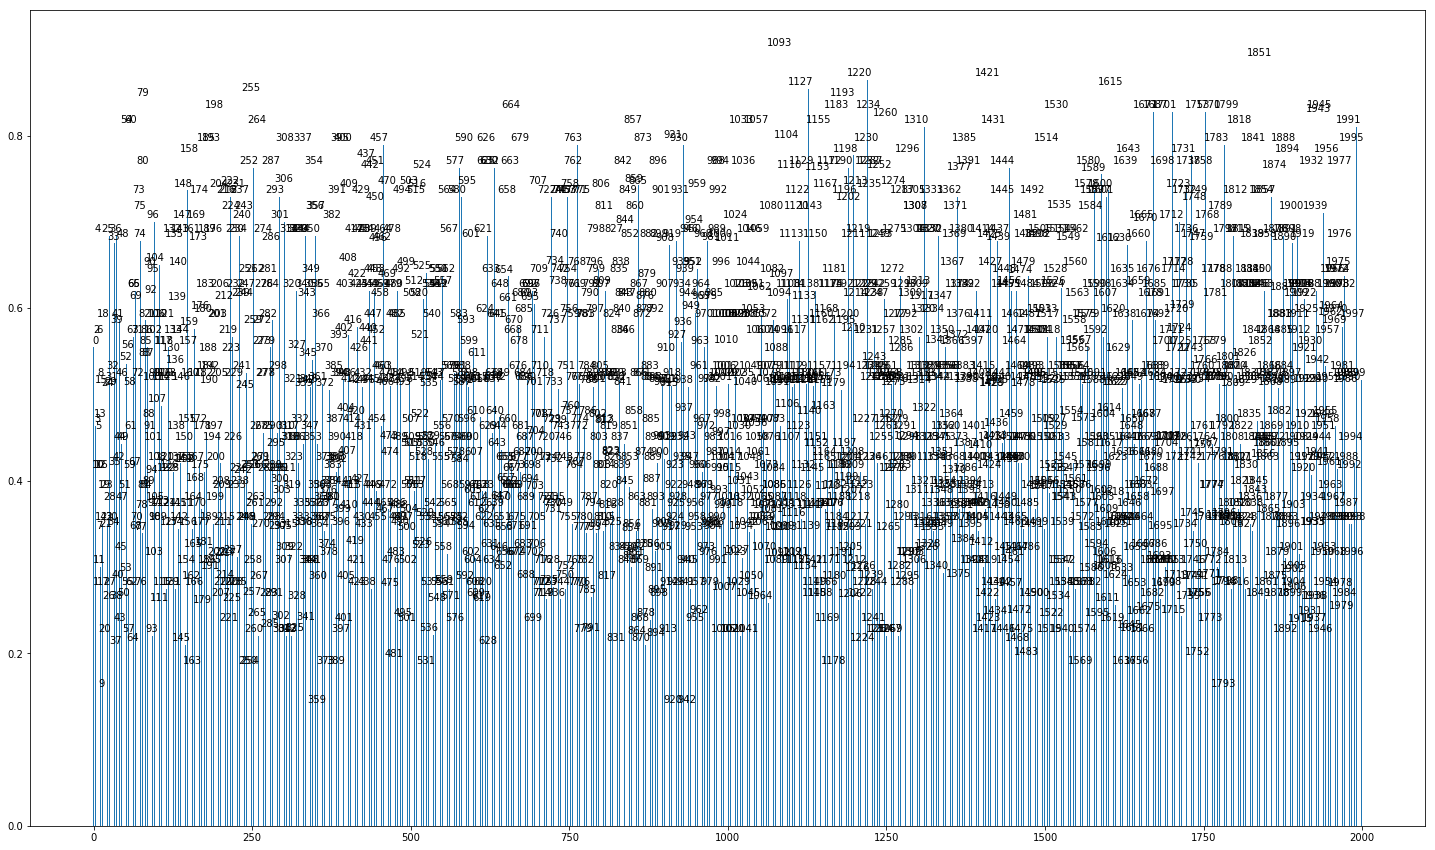

In [80]:
plt.figure(figsize=(25, 15))
all_points = np.array(range(0,2000))
plt.bar(range(0,2000),np.max(model_lda.doc_topic_,axis=1),width=0.3)
for i,label in enumerate(range(0,2000)):
    x = all_points[i]
    y = np.max(model_lda.doc_topic_,axis=1)[i]
    plt.annotate(i,xy=(x,y),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')



** Plot Convergence of LDA **

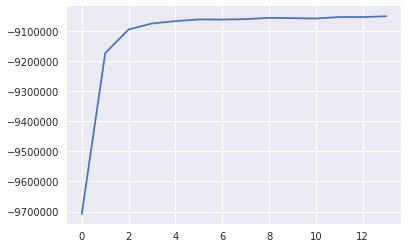

In [405]:
plt.plot(model_lda_b5_av_5.loglikelihoods_[1:])

In [369]:
model_lda_b5_av.loglikelihoods_[1:]

[-10270070.211481115,
 -9505632.603808338,
 -9395626.68739217,
 -9366752.757704495,
 -9353793.756832907,
 -9340584.82609745,
 -9335542.995463355,
 -9331000.177283911,
 -9328904.780165762,
 -9324008.848883342,
 -9324179.287879717,
 -9324403.474116823,
 -9324001.969559964,
 -9320415.00320904]

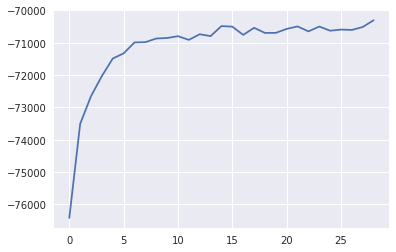

In [177]:
plt.plot(model_lda_b5_av.loglikelihoods_[1:])

In [218]:
topic_b5_av_c = np.load("model_lda_b5_av_topic_c.npy")
topic_b5_max_c = np.load("model_lda_b5_max_topic_c.npy")
topic_b5_av_c_comp = np.load("model_lda_b5_av_comp_c.npy")
topic_b5_max_c_comp = np.load("model_lda_b5_av_comp_c.npy")
topic_b5_av_n_comp = np.load("model_lda_b5_av_comp_n.npy")
topic_b5_max_n_comp = np.load("model_lda_b5_max_comp_n.npy")
#np.save("model_lda_b5_max_topic_c.npy",model_lda_b5_max.doc_topic_)
#np.save("model_lda_b5_av_comp_c.npy",model_lda_b5_av.components_)
#np.save("model_lda_b5_av_comp_c.npy",model_lda_b5_max.components_)

In [ ]:
topic_b5_av_n_comp = np.load("model_lda_b5_av_comp_n.npy")
#np.save("model_lda_b5_max_comp_n.npy",model_lda_b5_max.components_)

In [461]:
adjusted_rand_score(np.argmax(model_lda_b5_av.doc_topic_,axis=1),np.argmax(model_lda_b2_av.doc_topic_,axis=1))

0.04802338540627367

In [148]:
prediction_b5_av = np.argmax(model_lda_b5_av.doc_topic_,axis=1)

In [149]:
prediction_b5_max = np.argmax(model_lda_b5_max.doc_topic_,axis=1)

In [94]:
from sklearn.metrics.cluster import adjusted_rand_score

In [150]:
adjusted_rand_score(prediction_b5_av,prediction_b5_max)

0.27228260253681874

In [151]:
sklearn.metrics.cluster.adjusted_rand_score(prediction_b5_max,prediction_b5_av)

0.27228260253681874

In [182]:
model_lda.nzw_.shape

(20, 512)

In [205]:
model_lda.ndz_

array([[2, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [219]:
model_lda.ndz_[0,:]

array([2, 0, 0, 6, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [157]:
model_lda.components_[0,:].shape

(128,)

<Container object of 128 artists>

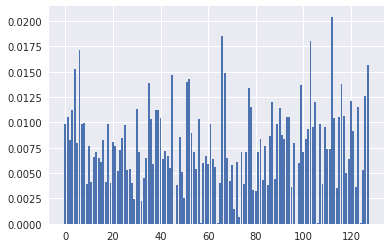

In [158]:
plt.bar(range(0,128),model_lda.components_[0,:])

<Container object of 512 artists>

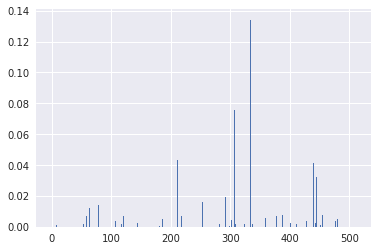

In [217]:
plt.bar(range(0,512),topic_b5_av_n_comp[0,:])

<Container object of 512 artists>

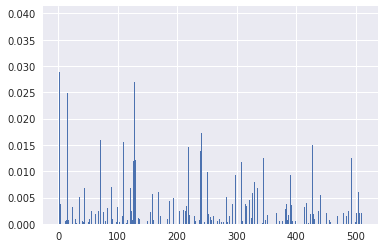

In [219]:
plt.bar(range(0,512),topic_b5_av_c_comp[0,:])

In [216]:
topic_b5_av_n_comp[0,:].shape

(512,)

<Container object of 10 artists>

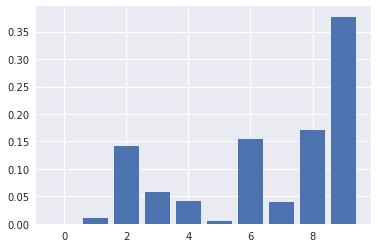

In [159]:
plt.bar(range(0,10),model_lda.doc_topic_[0,:])

In [48]:
np.sum([topic_prob*(np.exp(np.sum(np.log(model_lda.components_[i,:])))) for i,topic_prob in enumerate(model_lda.doc_topic_[4,:])])


0.0

In [38]:
plt.bar(range(0,512),model_lda.components_[0,:])

0.0

In [45]:
np.sum(np.log(model_lda.components_[0,:]))

-5120.89096793468

In [29]:
2 ** (-np.log2(val)/np.sum(processed_features_subset[0,:]))

/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.


inf

In [19]:
-np.log2(val)

/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.


inf

In [181]:
#perplexity - 2^(-log2(prob)/n)
all_perplexity_per_doc = []
for doc in range(0,2000):
    perplexity_per_doc = np.sum([topic_prob*np.prod(model_lda.components_[i,:]) for i,topic_prob in enumerate(model_lda.doc_topic_[doc,:])])
    print(perplexity_per_doc)
    all_perplexity_per_doc.append(2 ** (-np.log2(perplexity_per_doc)/np.sum(processed_features_subset[doc,:])))
    #perplexity = 2 ** (-np.log2(perplexity_per_doc)/np.sum(processed_features_subset[doc,:]))
all_perplexity_per_doc = np.asarray(all_perplexity_per_doc)

3.154621081731969e-293
1.9355675351955857e-288
3.143540899282721e-288
3.373492029290696e-288
2.1748406880018302e-288
1.3078530675159009e-288
2.3456127679332643e-288
8.314832433319354e-289
2.2567004598888977e-288
2.4812126947146744e-288
1.6049040990913002e-288
1.6751812795768037e-288
2.0561635054981393e-288
3.290813990051419e-288
3.665931911112846e-288
1.8984097507500043e-288
1.5905709020473576e-288
2.8803916678532753e-288
1.0142642151410523e-288
1.9577814609677105e-288
2.9423433811623294e-288
2.8134174974278256e-288
1.8691377874266117e-288
5.626045390075348e-289
1.2769758090552242e-288
3.87363152370286e-288
1.5871766482264715e-288
2.8594806338842665e-288
2.5410571903477528e-288
1.3399128085236282e-288
2.1168265402290116e-288
1.4774866956841603e-288
3.654399314606471e-288
1.2588687321310363e-288
1.9295999925304767e-288
2.309894632711319e-288
1.8418178089463277e-288
3.036462436652188e-288
3.301313868865471e-288
1.8318287477296123e-288
1.505053380651759e-288
2.1383642399089696e-288
2.6406

In [182]:
all_perplexity_per_doc.shape

(2000,)

(array([ 92., 478., 668., 482., 188.,  54.,  19.,  14.,   2.,   3.]),
 array([1.022563  , 1.02934272, 1.03612244, 1.04290216, 1.04968189,
        1.05646161, 1.06324133, 1.07002106, 1.07680078, 1.0835805 ,
        1.09036022]),
 <a list of 10 Patch objects>)

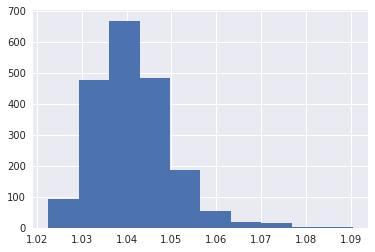

In [180]:
plt.hist(all_perplexity_per_doc)

## Visualisation of LDA wrt image labels

In [116]:
# RE-IMPLEMENT!!!
def plot_with_labels(lowDWeights, labels, filename='tsne.png'):
    assert lowDWeights.shape[0] >= len(labels), "More labels than weights"
    plt.figure(figsize=(10, 10))  #in inches

    for i,label in enumerate(labels):
        
        x, y = lowDWeights[i,:]
        if label == 'menu': #negative
            plt.scatter(x, y,c='orange')
        elif label == 'drink': #neutral
            plt.scatter(x, y,c='green')
        elif label == 'inside': #neutral
            plt.scatter(x, y,c='blue')
        elif label == 'outside': #neutral
            plt.scatter(x, y,c='yellow')
        elif label == 'food': #neutral
            plt.scatter(x, y,c='purple')
        #plt.annotate(i,
        #         xy=(x, y),
        #         xytext=(5, 2),
        #       textcoords='offset points',
        #        ha='right',
        #         va='bottom')

    #plt.savefig(filename)

In [65]:
chr(0)

'\x00'

In [ ]:
def save_tsne_plot_as_txt(tsne_low_dim_rep,labels,fname):
    with open(fname, 'w') as f:
          f.write("x y l\n")
          for i in range(tsne_low_dim_rep.shape[0]):
            f.write("%s %s %s\n" %(tsne_low_dim_rep[i,0],tsne_low_dim_rep[i,1],chr(labels[i])))

In [406]:
tsne1 = TSNE(perplexity=40, n_components=2, init='pca', n_iter=5000)
plot_only = 2000
lowDWeights1 = tsne1.fit_transform(model_lda_b5_av_5.doc_topic_)


In [407]:
tsne2 = TSNE(perplexity=40, n_components=2, init='pca', n_iter=5000)
plot_only = 2000
lowDWeights2 = tsne2.fit_transform(model_lda_b5_av_40.doc_topic_)



In [462]:
#np.save("tsne_weights_b2_av_c_p40_10.npy",lowDWeights1)
#np.save("tsne_weights_b5_av_c_p40_10.npy",lowDWeights2)
#np.save("tsne_weights_b5_max_c_p40_10.npy",lowDWeights1)
np.save("tsne_weights_b5_av_c_p40_5.npy",lowDWeights1)
np.save("tsne_weights_b5_av_c_p40_40.npy",lowDWeights2)

In [256]:
labels = final_labels

In [257]:
final_labels.shape

(2000,)

In [258]:
new_labels = []
for label in labels:
    if label == 'menu': #negative
        new_labels.append(0)
    elif label == 'drink': #neutral
        new_labels.append(1)
    elif label == 'inside': #neutral
        new_labels.append(2)
    elif label == 'outside': #neutral
        new_labels.append(3)
    elif label == 'food': #neutral
        new_labels.append(4)
new_labels = np.asarray(new_labels)

In [409]:
labels2 = np.argmax(model_lda_b5_av_5.doc_topic_,axis=1)

In [438]:
#np.save("labels_b2_av_c_p40_10.npy",labels2)
#np.save("labels_b5_max_c_p40_10.npy",labels2)
#np.save("labels_b5_av_c_p40_5.npy",labels2)

In [410]:
labels3 = np.argmax(model_lda_b5_av_40.doc_topic_,axis=1)

In [439]:
#np.save("labels_b5_av_c_p40_10.npy",labels3)
#np.save("labels_b5_max_c_p40_10.npy",labels2)
#np.save("labels_b5_av_c_p40_40.npy",labels3)

In [261]:
collections.Counter(labels)

Counter({'drink': 68, 'food': 1259, 'inside': 478, 'menu': 15, 'outside': 180})

In [411]:
class_count_b5_av_5 = collections.Counter(labels2)

In [284]:
class_count_b2_av

Counter({0: 1147, 2: 12, 5: 82, 6: 18, 7: 16, 8: 85, 9: 640})

In [412]:
class_count_b5_av_40 = collections.Counter(labels3)

In [112]:
class_count

Counter({0: 174,
         1: 199,
         2: 94,
         3: 77,
         4: 166,
         5: 30,
         6: 325,
         7: 338,
         8: 75,
         9: 522})

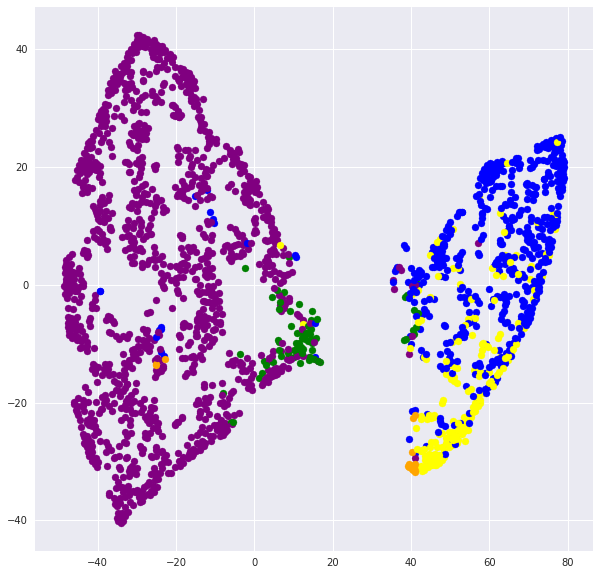

In [413]:
# 4 clusters p = 40
plot_with_labels(lowDWeights1, labels, str(1*100)+'.png')

MAX


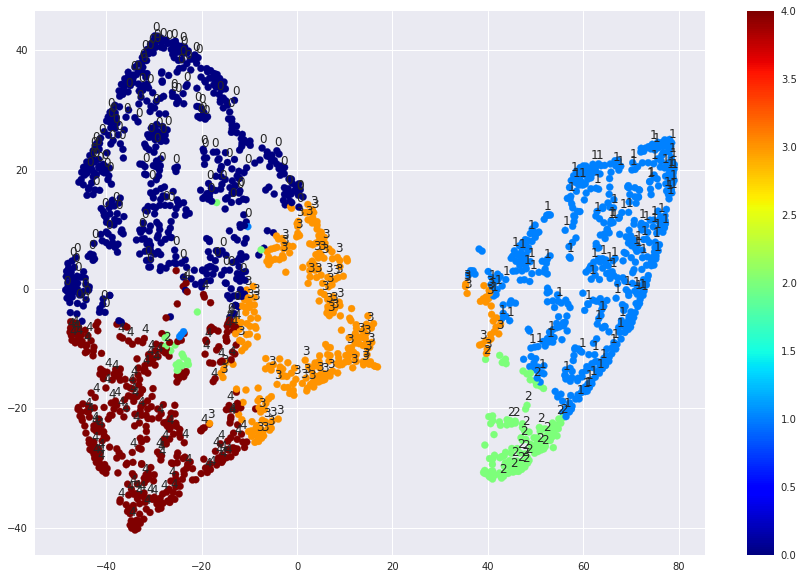

In [414]:
#cmap1 = plt.cm.get_cmap('jet', labels2)
print("MAX")
plt.figure(figsize=(15, 10))
plt.scatter(lowDWeights1[:,0],lowDWeights1[:,1],c=labels2,cmap='jet')
#plt.legend(handles=[val])
plt.colorbar()
for i,label in enumerate(labels2):
    x, y = lowDWeights1[i,:]
    if(i%5 == 0):
        plt.annotate(label,xy=(x,y),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')



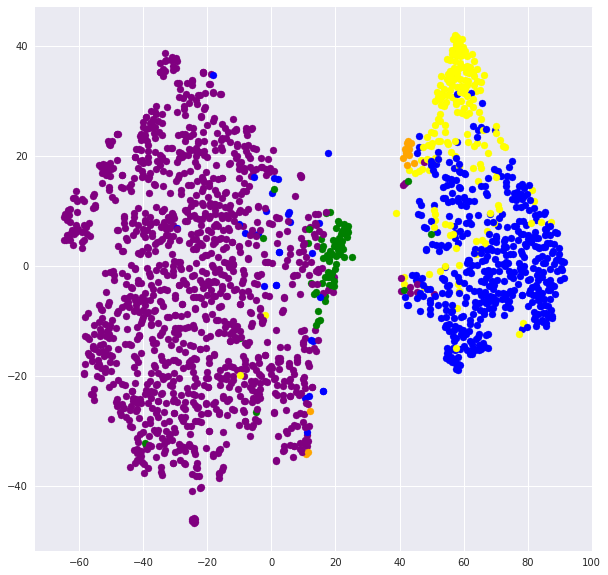

In [415]:
# 4 clusters p = 40
plot_with_labels(lowDWeights2, labels, str(1*100)+'.png')

AVERAGE


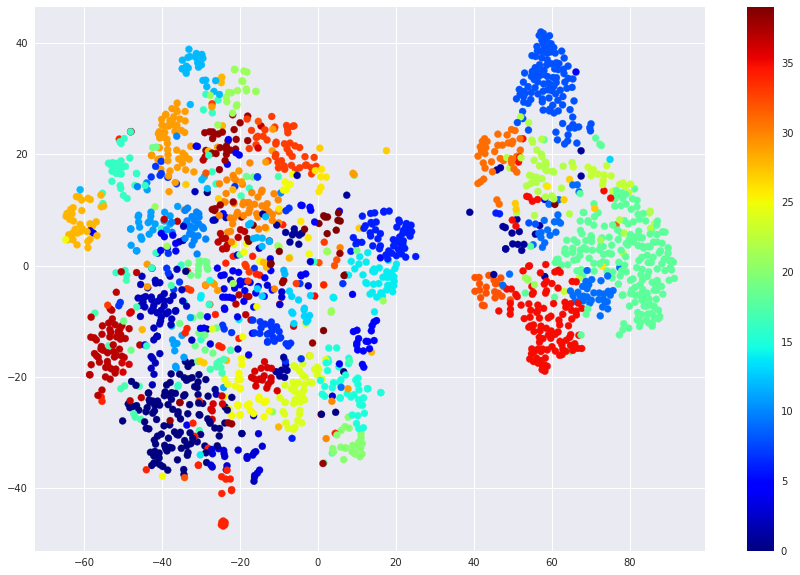

In [460]:
#cmap1 = plt.cm.get_cmap('jet', labels2)
print("AVERAGE")
plt.figure(figsize=(15, 10))
plt.scatter(lowDWeights2[:,0],lowDWeights2[:,1],c=labels3,cmap='jet')
#plt.legend(handles=[val])
plt.colorbar()
for i,label in enumerate(labels3):
    x, y = lowDWeights2[i,:]
    #if(i%5 == 0):
    #   plt.annotate(label,xy=(x,y),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')




b2 av
class 0 - black, brown, white
class 2 - very dark - bright in the middle
class 5 - white background
class 7 - red coloured
class 8 - white green red

b5 av
class 2 - drinks
class 3 - inside + dark
class 6 - circular shaped foods (dark background) (6 and 9 close together)
class 9 - circular shaped foods (light background)
class 7 - outside

b5 max

class 0 - drinks
class 1- circular shaped foods (general)
class 2 - outside
class 3 - food, bright green, white plates
class 8 - people
class 9 - mixture between inside and outside


b5 av (5)

class 2 - text, menu, signs
class 4 - circular shaped foods (general)
class 0 - non-circular food
class 1 - inside
class 3 - combo of drink and food

b5 av (40)

class 6 - drinks
class 31 - text, menu, signs (majority menu only)
class 29 - sandwiches, burgers
class 30 - food, square plates
class 2 - brown meat
category 12 - brown plates/ wraps
category 22 - inside (wood, chairs)
category 18 - inside (dark, chairs at tables)
category 28 - pizza

57
[34 24 43  5 47  6 38 22 29 55 30 35 39 42 19  9 36  1 32 11]


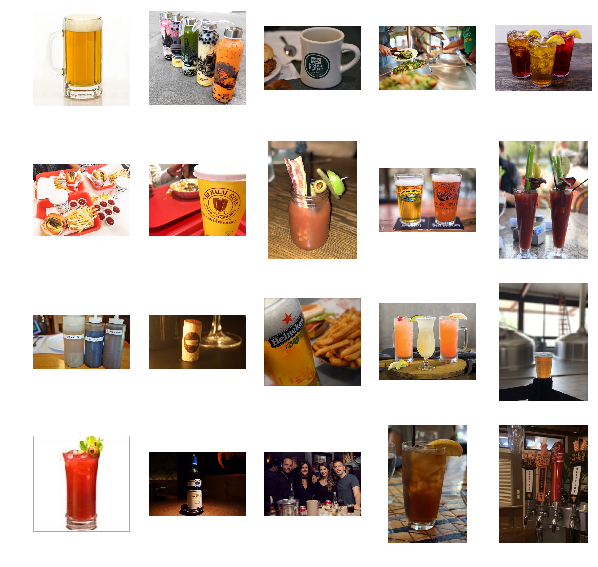

In [475]:
category = 6
cat_ind = (np.argmax(model_lda_b5_av_40.doc_topic_,axis=1) == category)
num_in_class = class_count_b5_av_40[category]
print(num_in_class)
if(num_in_class < 20):
    num_images = num_in_class
else:
    num_images = 20
with matplotlib.rc_context({'figure.figsize': [10,10], 'axes.titlesize': 10}):
    fig = plt.figure()
    val = np.random.choice(range(0,num_in_class),size=(num_images),replace=False)
    print(val)
    for i,num in enumerate(range(0,num_images)):
        cat_names = names_subset[cat_ind] 
        img = PIL.Image.open(cat_names[val[i]])
        plt.subplot(4,5,i+1)
        plt.axis('off')
        plt.imshow(img)
        

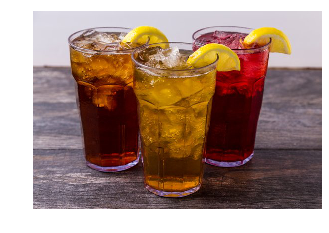

In [476]:
with matplotlib.rc_context({'figure.figsize': [30,25], 'axes.titlesize': 10}):
    fig = plt.figure()
    img = PIL.Image.open(names_subset[cat_ind][47])
    plt.subplot(4,5,i+1)
    plt.axis('off')
    plt.imshow(img)

In [287]:
class_count_b2_av

Counter({0: 1147, 2: 12, 5: 82, 6: 18, 7: 16, 8: 85, 9: 640})

In [471]:
image_num = 55
#cat 11, im = 1224

NameError: name 'model_lda' is not defined

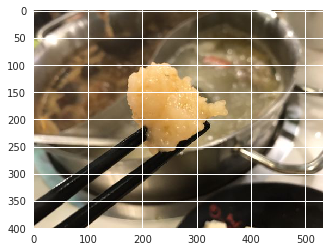

In [472]:
img = PIL.Image.open(names_subset[image_num])
plt.imshow(img)
class_val = np.argmax(model_lda.doc_topic_[image_num,:])
print(class_val)

In [88]:
print(np.argsort(model_lda.doc_topic_[image_num,:]))
model_lda.doc_topic_[image_num,:]

[ 0 17 16 12 11 18  8  9  6  4  3  2  1 19  5 10 13 14 15  7]


array([0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.1375, 0.0125, 0.1375,
       0.0125, 0.0125, 0.1375, 0.0125, 0.0125, 0.1375, 0.1375, 0.1375,
       0.0125, 0.0125, 0.0125, 0.0125])

<Container object of 20 artists>

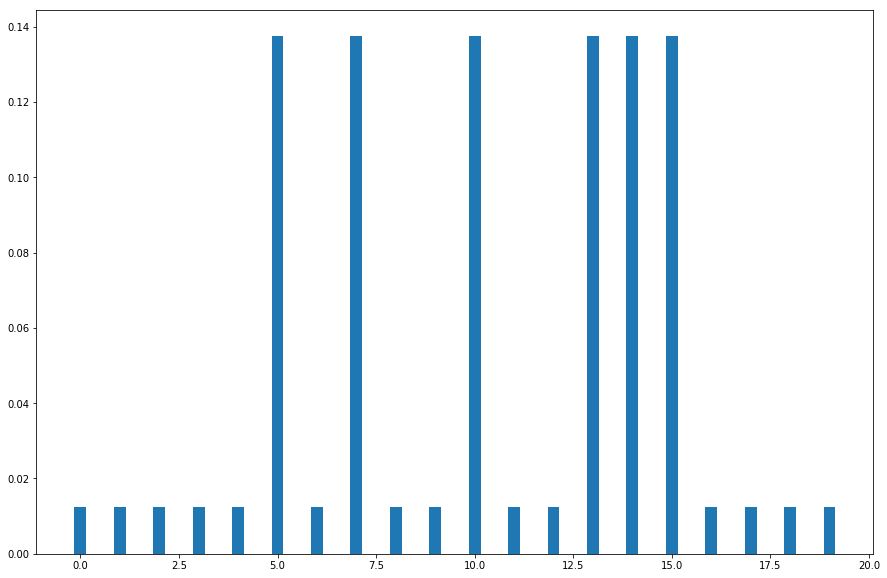

In [89]:
plt.figure(figsize=(15, 10))
#all_points = np.array(range(0,2000))
plt.bar(range(0,20),model_lda.doc_topic_[image_num,:],width=0.3)

In [326]:
category = 9
cat = (np.argmax(model_lda_b2_av.doc_topic_,axis=1) == category)
indx = [i for i, x in enumerate(cat) if x]

In [327]:
len(indx)

640

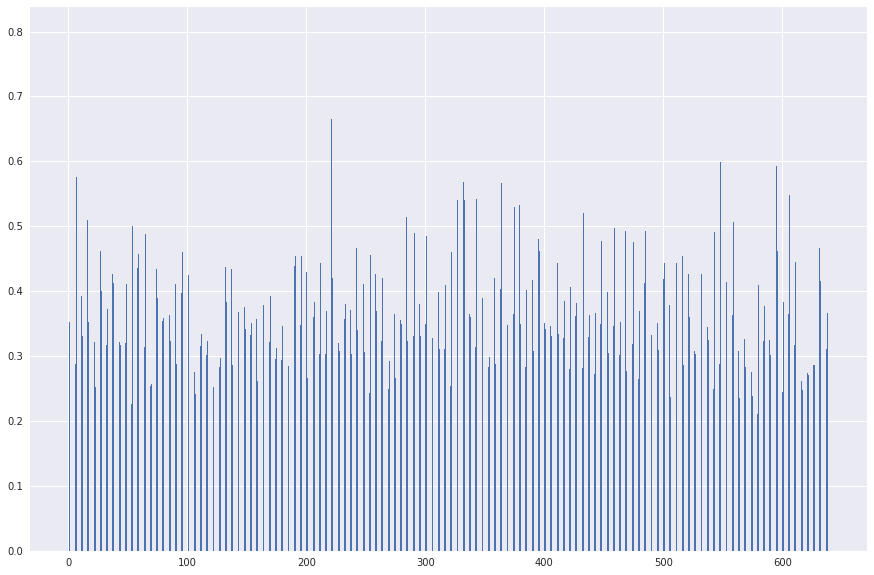

In [328]:
plt.figure(figsize=(15, 10))
#all_points = np.array(range(0,2000))
plt.bar(range(0,class_count_b2_av[category]),np.max(model_lda_b2_av.doc_topic_[indx,:],axis=1),width=0.3)
label_cat = indx
for i,label in enumerate(range(0,class_count_b2_av[category])):

    x = i
    y = np.max(model_lda_b2_av.doc_topic_[indx,:],axis=1)[i]
    #plt.annotate(label_cat[i],xy=(x,y),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')


In [331]:
np.max(model_lda_b2_av.doc_topic_[indx,:],axis=1).shape

(640,)

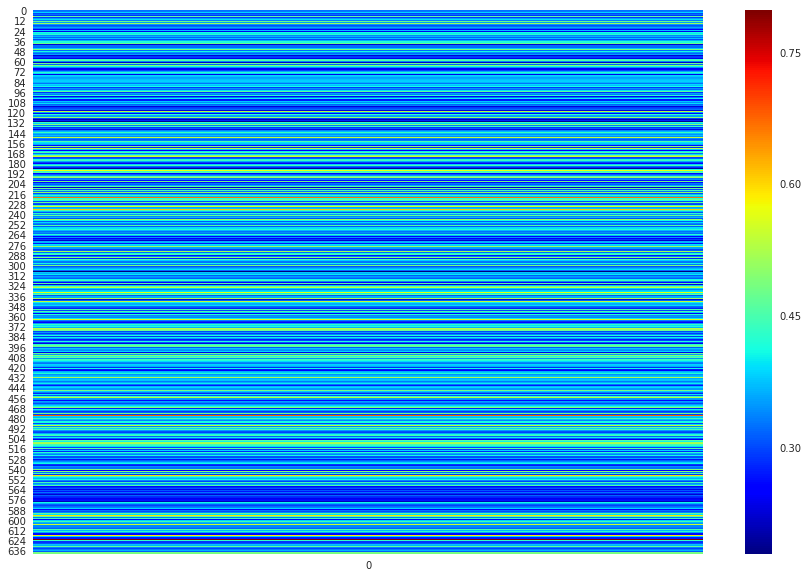

In [341]:
category = 9
sns.set()
num_in_class = class_count_b2_av[category]
cat = (np.argmax(model_lda_b2_av.doc_topic_,axis=1) == category)
indx = [i for i, x in enumerate(cat) if x]
with matplotlib.rc_context({'figure.figsize': [15,10], 'axes.titlesize': 10}):
    fig = plt.figure()
    sns.heatmap(np.reshape(np.max(model_lda_b2_av.doc_topic_[indx,:],axis=1),(num_in_class,1)),cmap="jet")

In [137]:
import seaborn as sns

In [30]:
model_lda.doc_topic_

array([[1.92678227e-04, 1.92678227e-04, 1.92678227e-04, ...,
        4.04624277e-03, 2.11946050e-03, 1.75337187e-02],
       [9.22844175e-03, 1.51285930e-04, 1.51285930e-04, ...,
        1.51285930e-04, 1.15128593e-01, 1.51285930e-04],
       [1.18623962e-04, 9.73902728e-02, 1.18623962e-04, ...,
        1.18623962e-04, 1.30486358e-03, 1.18623962e-04],
       ...,
       [1.00100100e-04, 3.51351351e-02, 3.61361361e-02, ...,
        1.00100100e-04, 1.01201201e-01, 1.23223223e-01],
       [1.26422250e-04, 1.26422250e-04, 1.26422250e-04, ...,
        1.26422250e-04, 1.26422250e-04, 8.97597977e-03],
       [1.29701686e-04, 1.15564202e-01, 1.29701686e-04, ...,
        7.91180285e-03, 5.07133593e-02, 1.29701686e-04]])

In [87]:
topic_ordered = np.argsort(np.argmax(model_lda.doc_topic_,axis=1))

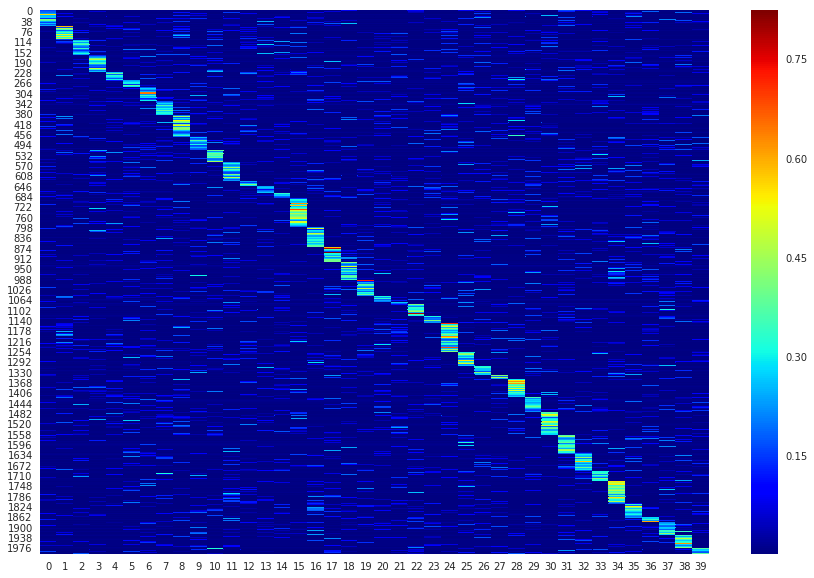

In [211]:
sns.set()
topic_ordered = np.argsort(np.argmax(model_lda_b5_max.doc_topic_,axis=1))
with matplotlib.rc_context({'figure.figsize': [15,10], 'axes.titlesize': 10}):
    fig = plt.figure()
    sns.heatmap(model_lda_b5_max.doc_topic_ [topic_ordered,:],cmap="jet")

## rich get richer - bigger clusters get bigger over time and smaller clusters get smaller (because of way update prior) so when topic number increases, the size of the clusters are relatively similar and can therefore find drink topics are more low level similarities

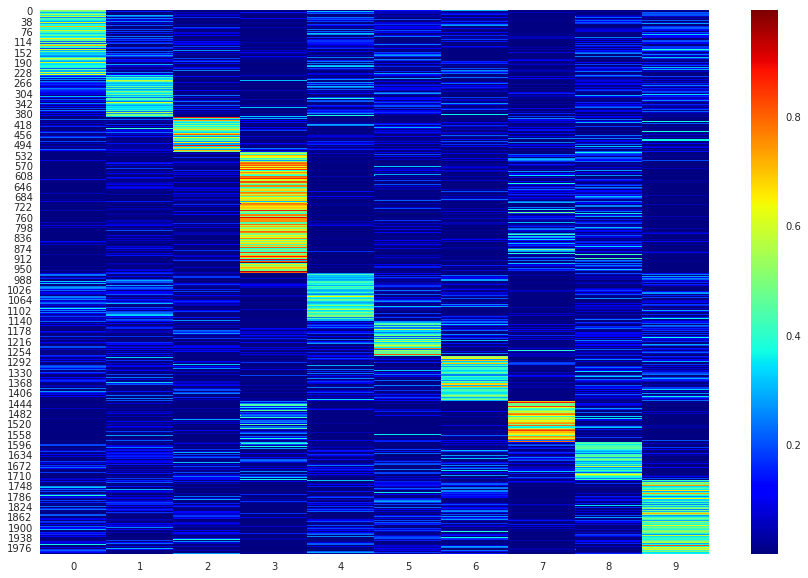

In [381]:
sns.set()
topic_ordered = np.argsort(np.argmax(model_lda_b5_av.doc_topic_,axis=1))
with matplotlib.rc_context({'figure.figsize': [15,10], 'axes.titlesize': 10}):
    fig = plt.figure()
    sns.heatmap(model_lda_b5_av.doc_topic_ [topic_ordered,:],cmap="jet")

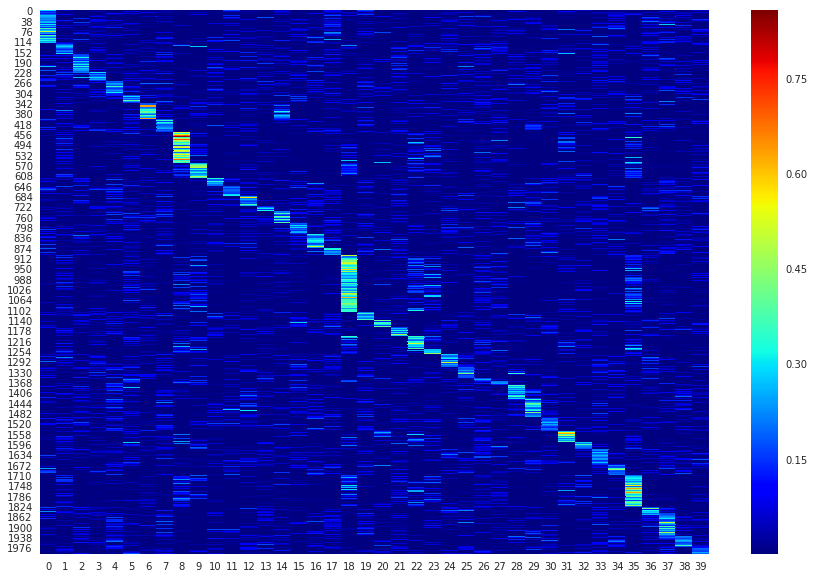

In [437]:
sns.set()
topic_ordered = np.argsort(np.argmax(model_lda_b5_av_40.doc_topic_,axis=1))
with matplotlib.rc_context({'figure.figsize': [15,10], 'axes.titlesize': 10}):
    fig = plt.figure()
    sns.heatmap(model_lda_b5_av_40.doc_topic_ [topic_ordered,:],cmap="jet")

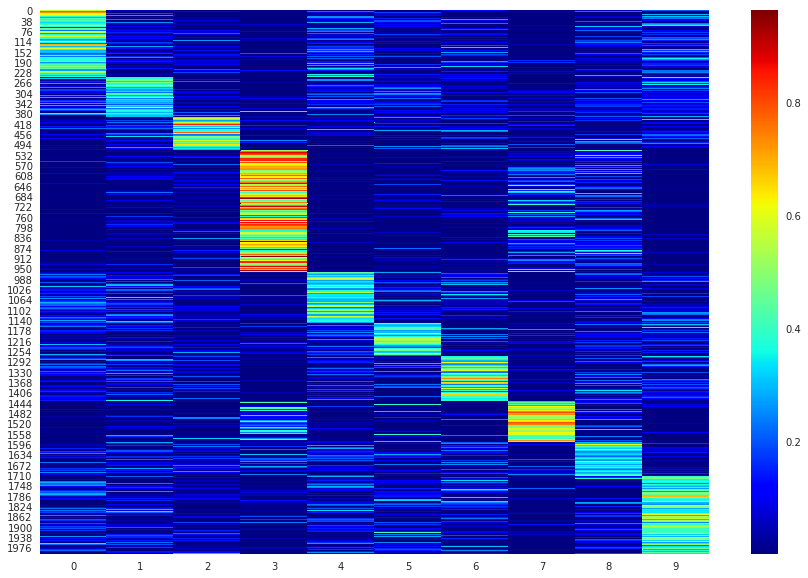

In [191]:
sns.set()
topic_ordered = np.argsort(np.argmax(topic_b5_av_c,axis=1))
with matplotlib.rc_context({'figure.figsize': [15,10], 'axes.titlesize': 10}):
    fig = plt.figure()
    sns.heatmap(topic_b5_av_c [topic_ordered,:],cmap="jet")

determining modesl given some words for a given topic 